## Table of contents

* [Loading packages](#loading_packages)
    * [Section 1.1: Excel file name explanation](#excelexplain)
    * [Section 1.2: Loading packages](#loading_packages)
* [Random Forest](#rf)
* [Gradient Boosting Machine](#gbm)
* [SVM](#svm)
* [Penalized Multinomial Logistic Regression](#multinom)
* [Deep Neural Network](#dnn)

#### Excel file name explanation <a class="anchor" id="excelexplain"></a>

- USSB are Store-bought samples
- USE are Environmental samples

### Loading packages <a class="anchor" id="loading_packages"></a>

In [22]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import openpyxl
import timeit
import re
import os
import glob
import xgboost
import lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from matplotlib import pyplot
from V4_2_Fingerprinting_Workflow_SVC_beta_version_python import fingerprintingWorkflow
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, cohen_kappa_score, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from collections import Counter

# import tensorflow as tf
import random
plt.rcParams['figure.figsize'] = [10, 10]

### Demonstration of Stratified k-fold cross-validation

### Data Import from R  <a class="anchor" id="Data Import from R"></a>

In [10]:
subcat_wd = os.getcwd() + "/MLdata_USEonly"

#### GC-MS data

##### Subcategory

In [11]:
# Load xlsx exported from df_pca

p1 =  subcat_wd + "/gc_zero-reduc.xlsx"
p2 = subcat_wd + "/gc_zero_no-reduc.xlsx"
# p3 = subcat_wd + "/gc_lod.xlsx"

gc_zero_reduc = pd.read_excel(p1)
gc_zero_no_reduc = pd.read_excel(p2)
# gc_lod = pd.read_excel(p3)

##### Category

In [ ]:
files_zero = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/gc_cat*_zero.xlsx")
files_min = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/gc_cat*_min.xlsx")
files_lod = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/gc_cat*_lod.xlsx")

gc_cat_zero = []
for file in files_zero:
    df = pd.read_excel(file)
    gc_cat_zero.append(df)

gc_cat_min = []
for file in files_min:
    df = pd.read_excel(file)
    gc_cat_min.append(df)

gc_cat_lod = []
for file in files_lod:
    df = pd.read_excel(file)
    gc_cat_lod.append(df)

#### HPLC_qTOF-MS data

##### Subcategory

In [12]:
# Load xlsx exported from df_pca

p1 = subcat_wd + "/hplc_zero-reduc.xlsx"
p2 = subcat_wd + "/hplc_zero_no-reduc.xlsx"
# p3 = subcat_wd + "/hplc_lod.xlsx"

hplc_zero_reduc = pd.read_excel(p1)
hplc_zero_no_reduc = pd.read_excel(p2)
# hplc_lod = pd.read_excel(p3)

##### Category

In [ ]:
files_zero = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/hplc_cat*_zero.xlsx")
files_min = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/hplc_cat*_min.xlsx")
files_lod = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/hplc_cat*_lod.xlsx")

hplc_cat_zero = []
for file in files_zero:
    df = pd.read_excel(file)
    hplc_cat_zero.append(df)

hplc_cat_min = []
for file in files_min:
    df = pd.read_excel(file)
    hplc_cat_min.append(df)

hplc_cat_lod = []
for file in files_lod:
    df = pd.read_excel(file)
    hplc_cat_lod.append(df)

#### ICP-TRace-Metal data

##### Subcategory

In [13]:
p1 = subcat_wd + "/icp.xlsx"

icp_all = pd.read_excel(p1)

##### Category

In [ ]:
files = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/icp_cat*.xlsx")

icp_cat = []
for file in files:
    df = pd.read_excel(file)
    icp_cat.append(df)

#### Combined GC-HPLC data

##### Subcategory

In [37]:
# Load xlsx exported from df_pca

p1 = subcat_wd +"/gc_hplc-reduc.xlsx"
p2 = subcat_wd +"/gc_hplc_no-reduc.xlsx"
# p3 = subcat_wd +"/gchplc_lod.xlsx"

gc_hplc_zero_reduc = pd.read_excel(p1)
gc_hplc_zero_no_reduc = pd.read_excel(p2)
# gc_hplc_lod = pd.read_excel(p3)

##### Category

In [ ]:
files_zero = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/gc_hplc_cat*_zero.xlsx")
files_min = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/gc_hplc_cat*_min.xlsx")
files_lod = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/gc_hplc_cat*_lod.xlsx")

gc_hplc_cat_zero = []
for file in files_zero:
    df = pd.read_excel(file)
    gc_hplc_cat_zero.append(df)

gc_hplc_cat_min = []
for file in files_min:
    df = pd.read_excel(file)
    gc_hplc_cat_min.append(df)

gc_hplc_cat_lod = []
for file in files_lod:
    df = pd.read_excel(file)
    gc_hplc_cat_lod.append(df)

#### Combined GC-ICP data

##### Subcategory

In [38]:
# Load xlsx exported from df_pca

p1 = subcat_wd +"/gc_icp-reduc.xlsx"
p2 = subcat_wd +"/gc_icp_no-reduc.xlsx"
# p3 = subcat_wd +"/gcicp_lod.xlsx"
# 
gc_icp_zero_reduc = pd.read_excel(p1)
gc_icp_zero_no_reduc = pd.read_excel(p2)
# gc_icp_lod = pd.read_excel(p3)

##### Category

In [ ]:
files_zero = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/gc_icp_cat*_zero.xlsx")
files_min = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/gc_icp_cat*_min.xlsx")
files_lod = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/gc_icp_cat*_lod.xlsx")

gc_icp_cat_zero = []
for file in files_zero:
    df = pd.read_excel(file)
    gc_icp_cat_zero.append(df)

gc_icp_cat_min = []
for file in files_min:
    df = pd.read_excel(file)
    gc_icp_cat_min.append(df)

gc_icp_cat_lod = []
for file in files_lod:
    df = pd.read_excel(file)
    gc_icp_cat_lod.append(df)

#### Combined HPLC-ICP data

##### Subcategory

In [39]:
# Load xlsx exported from df_pca

p1 = subcat_wd +"/hplc_icp-reduc.xlsx"
p2 = subcat_wd +"/hplc_icp_no-reduc.xlsx"
# p3 = subcat_wd +"/hplcicp_lod.xlsx"

hplc_icp_zero_reduc = pd.read_excel(p1)
hplc_icp_zero_no_reduc = pd.read_excel(p2)
# hplc_icp_lod = pd.read_excel(p3)

##### Category

In [ ]:
files_zero = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/hplc_icp_cat*_zero.xlsx")
files_min = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/hplc_icp_cat*_min.xlsx")
files_lod = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/hplc_icp_cat*_lod.xlsx")

hplc_icp_cat_zero = []
for file in files_zero:
    df = pd.read_excel(file)
    hplc_icp_cat_zero.append(df)

hplc_icp_cat_min = []
for file in files_min:
    df = pd.read_excel(file)
    hplc_icp_cat_min.append(df)

hplc_icp_cat_lod = []
for file in files_lod:
    df = pd.read_excel(file)
    hplc_icp_cat_lod.append(df)

#### Combined GC-HPLC-ICP (Metal) data

##### Subcategory

In [41]:
# Load xlsx exported from df_pca

p1 = subcat_wd +"/gc_hplc_icp-reduc.xlsx"
p2 = subcat_wd +"/gc_hplc_icp_no-reduc.xlsx"
# p3 = subcat_wd +"/gchplcicp_lod.xlsx"

gc_hplc_icp_zero_reduc = pd.read_excel(p1)
gc_hplc_icp_zero_no_reduc = pd.read_excel(p2)
# gc_hplc_icp_lod = pd.read_excel(p3)

##### Category

In [ ]:
files_zero = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/gc_hplc_icp_cat*_zero.xlsx")
files_min = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/gc_hplc_icp_cat*_min.xlsx")
files_lod = glob.glob("C:/Users/Emerging contaminant/Desktop/Huy-Plastic-Fingerprint/Microplastic-Fingerprinting/ML_statsdata_Category/gc_hplc_icp_cat*_lod.xlsx")

gc_hplc_icp_cat_zero = []
for file in files_zero:
    df = pd.read_excel(file)
    gc_hplc_icp_cat_zero.append(df)

gc_hplc_icp_cat_min = []
for file in files_min:
    df = pd.read_excel(file)
    gc_hplc_icp_cat_min.append(df)

gc_hplc_icp_cat_lod = []
for file in files_lod:
    df = pd.read_excel(file)
    gc_hplc_icp_cat_lod.append(df)

### Feature correlation Analyses

In [ ]:
dat = hplc_list[2]
# Select relevant columns
dat = dat[['File', 'Category', 'Feature', 'Values']]

# Group by and take the mean of 'Values'
dat = dat.groupby(['File', 'Category', 'Feature']).agg({'Values': 'mean'}).reset_index() # 

# Pivot the table
dat = dat.pivot_table(index=['File', 'Category'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()

# Set 'File' as index (equivalent to rownames in R)
dat.set_index('File', inplace=True)

# Iterate through each row and replace NaNs
for idx, row in dat.iterrows():
    na_indices = row.isna()
    na_count = na_indices.sum()
    
    if na_count > 0:
        dat.loc[idx, na_indices.index[na_indices]] = 0

# Dropping the first column which contains the category names
df_pca_compounds = dat.drop(columns = ['Category'])
labels = dat['Category']

# Calculating the correlation matrix
correlation_matrix = df_pca_compounds.corr()

In [ ]:
# Setting a threshold for high correlation
high_corr_threshold = 0.99

# Finding pairs of compounds with high correlation & Excluding self-correlation
high_corr_pairs = correlation_matrix.abs().unstack()
high_corr_pairs = high_corr_pairs[high_corr_pairs >= high_corr_threshold]
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]
high_corr_pairs = high_corr_pairs.drop_duplicates()

# Displaying the highly correlated pairs
# high_corr_pairs.head(20)  # Displaying top 20 pairs for brevity

# Reducing the compound set to avoid redundancy
# For each pair of perfectly correlated compounds, we'll keep only one

# Creating a set to store the unique compounds
reduced_compound_set = set()

for pair in high_corr_pairs.index:
    # Adding only the first compound of each highly correlated pair to the set
    reduced_compound_set.add(pair[0])

# Converting the set to a list
reduced_compound_list = list(reduced_compound_set)

# Extracting the data for the reduced set of compounds
reduced_cluster_data = df_pca_compounds[reduced_compound_list]
reduced_cluster_data['Category'] = labels

### Random Forest <a class="anchor" id="rf"></a>

#### GridSearchCV - RFlable.

The grid search will: 

- Try every combination of your parameter grid
- For each of them it will do a K-fold cross validation
- Select the best available.

In [31]:
def rfsrc_result(dat,
                 type):
    
    # If a class only have 1 member then exclude that class from the ML
    # Count the frequency of each class
    class_counts = dat[type].astype(str).value_counts()
    # Filter out classes with only one member
    dat = dat[dat[type].astype(str).map(class_counts) > 1]
    
    # Extract the features and labels
    X = dat.drop(columns=[type])
    y = dat[type]
    
    # Then, split train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = round(len(dat[type].unique())/dat.shape[0], 2), # for case where only 1 sample/class
                                                        stratify = y, random_state=123)

    param_grid = {
    'n_estimators':  [1, 10, 50, 100, 500, 1000, 5000, 10000], # Generate an array of 100 stepwise values from 0 to 1000, 
    'max_features': ['sqrt', 'log2']
    }

    # The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf) 
    cv = RepeatedStratifiedKFold(n_splits = pd.DataFrame(y_train)[type].value_counts().min(),
                                 n_repeats = 10, random_state = 123)
    if pd.DataFrame(y_train)[type].value_counts().min() == 1:
        cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 10, random_state = 123)
    
    gridsearch = GridSearchCV(RandomForestClassifier(), 
                              param_grid=param_grid, 
                            # number of cv = number of member of classes with least no. of members
                            cv = cv,
                            scoring = 'balanced_accuracy',
                            return_train_score=True,
                            n_jobs = -1).fit(X_train, y_train)
    
    grid = gridsearch.best_params_

    # Monitoring split_test_score across different hyperparameters of GridSearch -------------------------------------------------------
    glued_dicts = ['_'.join([f"{key}_{value}" for key, value in d.items()]) for d in gridsearch.cv_results_['params']]
    split_test_scores_list = []
    
    # Iterate over each row
    for index, row in pd.DataFrame(gridsearch.cv_results_).iterrows():
        split_test_scores = []
        # Iterate over each column
        for column in pd.DataFrame(gridsearch.cv_results_).columns:
            # Check if column name matches the pattern "splitx_test_score"
            if column.startswith('split') and column.endswith('_test_score'):
                # Extract numerical value from the column
                split_test_score = row[column]
                split_test_scores.append(split_test_score)
        split_test_scores_list.append(split_test_scores)
    
    for name, scores in zip(glued_dicts, split_test_scores_list):
      # summarize progress along the way
     print('%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    # plot model performance for comparison
    plt.boxplot(split_test_scores_list, labels=glued_dicts, showmeans=True, showbox=True, showfliers=True, showcaps=True)
    plt.xticks(rotation=90)
    plt.show()
    
    # # Extracting relevant information from gridsearch results
    # results = gridsearch.cv_results_
    # params = results['params']
    
    # # Getting unique values of hyperparameters
    # n_estimators_values = np.unique([x['n_estimators'] for x in params])
    # max_features_values = np.unique([x['max_features'] for x in params])
    
    # # Plotting
    # plt.figure(figsize=(12, 8))
    
    # for max_features_value in max_features_values:
    #     for n_estimators_value in n_estimators_values:
    #         # Finding indices of hyperparameter combination in the results
    #         indices = [i for i, p in enumerate(params) if p['max_features'] == max_features_value and p['n_estimators'] == n_estimators_value]
            
    #         # Extracting mean train scores for this combination
    #         scores = [results[f'split{i}_test_score'][indices[0]] for i in range(1,10*pd.DataFrame(y_train)[type].value_counts().min())]  
    #         # Plotting
    #         plt.plot(range(1, 10*pd.DataFrame(y_train)[type].value_counts().min()), 
    #                  scores, label=f'n_estimators={n_estimators_value}, max_features={max_features_value}')
    
    # plt.xlabel('Split Number')
    # plt.ylabel('Test Score')
    # plt.title('Fluctuation of Train Score across Splits for Different Hyperparameter Combinations')
    # plt.legend(loc='lower right')
    # plt.grid(True)
    # plt.show()

    rf = RandomForestClassifier(n_estimators = grid['n_estimators'], max_features = grid['max_features'], random_state=123, oob_score=True, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Prediction results
    # For test set
    predictions_test = rf.predict_proba(X_test)
    pred_df_test = pd.DataFrame(predictions_test, columns=rf.classes_)

    # Assign true and predicted labels
    # For test set
    y_pred_test = pred_df_test.select_dtypes(include=[np.number]).idxmax(axis=1)
    
    # Balanced accuracy score
    print("Balanced Accuracy (testing):" + str(balanced_accuracy_score(y_test, y_pred_test)))

    # Cohen Kappa score
    print("Cohen Kappa score:" + str(cohen_kappa_score(y_test, y_pred_test)))
    
    # Generate confusion matrix of test set
    conf_matrix_sklearn = confusion_matrix(y_test, y_pred_test, labels=rf.classes_)
    
    print(classification_report(y_test, y_pred_test))
    report = pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).transpose()
    
    # To visualize the confusion matrix
    ConfusionMatrixDisplay(conf_matrix_sklearn,
                          display_labels=rf.classes_).plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.tight_layout()
    plt.show()

    # Histogram of distribution of probability of each class in prediction
    for column in pred_df_test.columns:
        # Create a histogram for the current column
        plt.hist(pred_df_test[column], bins=10, alpha=0.5, label=column)
        # Round up y-axis ticks to have no decimals
        plt.yticks(np.arange(plt.yticks()[0][0], plt.yticks()[0][-1] + 1, step=1))
        
        # Add title for each subplot as the name of the column
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    # Plot feature importance
    feature_imp = pd.DataFrame({'feature_score': rf.feature_importances_, # Feature scores range in [0,1] and sum up to 1.
                             'feature_name': dat.drop(columns=[type]).columns}).sort_values('feature_score')
    
    # Plot the top 25 most important features
    plt.barh(range(25), feature_imp.tail(n = 25).feature_score)
    plt.yticks(range(25), feature_imp.tail(n = 25).feature_name)
    plt.xlabel('Importance')
    plt.title('Variable Importance')
    plt.show()
    
    return rf, feature_imp, gridsearch.cv_results_

#### Classification with reduced feature data after correlation matrix analysis

For the case of HPLC only data, THe BA of this option is:
- 0.8 (hplc_list[0]) < 0.9 (of the original data with all features)
- 0.458 (hplc_list[1]) < 0.77 (of the original data with all features)
- 0.5714 (hplc_list[2]) < 0.714 (of the original data with all features)

==> It's not a good idea to try cut down the number of features

In [ ]:
clf = rfsrc_result(reduced_cluster_data,
                   type = 'Category',
                    split_train = 0.5)

#### Classification by Category

##### GC data

In [ ]:
# zero
for i in range(4):
    clf = rfsrc_result(gc_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = rfsrc_result(gc_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = rfsrc_result(gc_cat_lod[i],
                       type = 'Category')

##### HPLC data

In [ ]:
# zero
for i in range(4):
    clf = rfsrc_result(hplc_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = rfsrc_result(hplc_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = rfsrc_result(hplc_cat_lod[i],
                       type = 'Category')

##### ICP data

In [ ]:
for i in range(4):
    clf = rfsrc_result(icp_cat[i],
                       type = 'Category')

##### GC + ICP

In [ ]:
# zero
for i in range(4):
    clf = rfsrc_result(gc_icp_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = rfsrc_result(gc_icp_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = rfsrc_result(gc_icp_cat_lod[i],
                       type = 'Category')

##### HPLC + ICP

In [ ]:
# zero
for i in range(4):
    clf = rfsrc_result(hplc_icp_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = rfsrc_result(hplc_icp_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = rfsrc_result(hplc_icp_cat_lod[i],
                       type = 'Category')

##### GC + HPLC data

In [ ]:
# zero
for i in range(4):
    clf = rfsrc_result(gc_hplc_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = rfsrc_result(gc_hplc_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = rfsrc_result(gc_hplc_cat_lod[i],
                       type = 'Category')

##### GC + HPLC + ICP data

In [ ]:
# zero
for i in range(4):
    clf = rfsrc_result(gc_hplc_icp_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = rfsrc_result(gc_hplc_icp_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = rfsrc_result(gc_hplc_icp_cat_lod[i],
                       type = 'Category')

#### Classification By Subcategory

##### GC data

In [ ]:
clf, rf_topfeature_gc_zero_reduc = rfsrc_result(gc_zero_reduc,
                   type = 'Subcategory')

In [ ]:
clf, rf_topfeature_gc_zero_no_reduc = rfsrc_result(gc_zero_no_reduc,
                   type = 'Subcategory')

In [ ]:
# Min imputed
clf = rfsrc_result(gc_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD imputed
clf = rfsrc_result(gc_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### HPLC data

In [ ]:
clf, rf_topfeature_hplc_zero_no_reduc = rfsrc_result(hplc_zero_no_reduc,
                   type = 'Subcategory')

In [ ]:
clf, rf_topfeature_hplc_zero_reduc = rfsrc_result(hplc_zero_reduc,
                   type = 'Subcategory')

In [ ]:
# Min imputed
clf, rf_topfeature = rfsrc_result(hplc_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD imputed
clf, rf_topfeature = rfsrc_result(hplc_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### ICP data

In [ ]:
clf, rf_topfeature_icp, results = rfsrc_result(icp_all,
                   type = 'Subcategory')

##### GC + ICP

In [ ]:
clf, rf_topfeature_gc_icp_zero_no_reduc = rfsrc_result(gc_icp_zero_no_reduc,
                   type = 'Subcategory')

In [ ]:
clf, rf_topfeature_gc_icp_zero_reduc = rfsrc_result(gc_icp_zero_reduc,
                   type = 'Subcategory')

In [ ]:
# LOD imputed
clf = rfsrc_result(gc_icp_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### HPLC + ICP

In [ ]:
clf, rf_topfeature_hplc_icp_zero_no_reduc = rfsrc_result(hplc_icp_zero_no_reduc,
                   type = 'Subcategory')

In [ ]:
clf, rf_topfeature_hplc_icp_zero_reduc = rfsrc_result(hplc_icp_zero_reduc,
                   type = 'Subcategory')

In [ ]:
# LOD imputed
clf = rfsrc_result(hplc_icp_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### GC + HPLC data

In [ ]:
clf, rf_topfeature_gc_hplc_zero_no_reduc = rfsrc_result(gc_hplc_zero_no_reduc,
                   type = 'Subcategory')

In [ ]:
clf, rf_topfeature_gc_hplc_zero_reduc = rfsrc_result(gc_hplc_zero_reduc,
                   type = 'Subcategory')

In [ ]:
# LOD imputed
clf = rfsrc_result(gc_hplc_lod.drop(columns=['technique']),
                   type = c)

##### GC + HPLC + ICP data

In [ ]:
clf, rf_topfeature_gc_hplc_icp_zero_no_reduc = rfsrc_result(gc_hplc_icp_zero_no_reduc,
                   type = 'Subcategory')

In [ ]:
clf, rf_topfeature_gc_hplc_icp_zero_reduc = rfsrc_result(gc_hplc_icp_zero_reduc,
                   type = 'Subcategory')

In [ ]:
# LOD imputed
clf = rfsrc_result(gc_hplc_icp_lod.drop(columns=['technique']),
                   type = 'Subcategory')

### Gradient-Boosting Method <a class="anchor" id="gbm"></a>

#### XGBoost <a class="anchor" id="xgboost"></a>

Update 16 April 2024:
With GC or ICP data only, maybe consider temporary exclude it from XGBoost because problem in sample size and also there is instrumental error which creates a massive outlier sample that have absurbly high signal intensity in all trace metal than any other samples (almost 2-3x higher than normal)!!!

==> because for each plastic product at the moment, we only have 3 replication. In the train_test_split with stratify y, 

==>> The test_size should be greater or equal to the number of classes

==> test_size is calculated = number of unique classes / number of samples

==> train dataset have problem where a class only have 1 sample => impossible to do k-fold cross-validation 

=++= Also I tried to use the faulty input data (with the crazy outlier sample) to put through  k-fold cross-validation and XGBoost ==> the accuracy after k-fold cv is horrible: 0.083 

==> However, it is still possible to run k-fold cv and ML classifier with combination of analytical techniques because it actually increase the sample size (i.e., the analytical dataset with bigger sample size compensate for the one with lower sample size and when pool everything together, there are more samples per classes)!!

In [42]:
dat = gc_hplc_zero_reduc
# If a class only have 1 member then exclude that class from the ML
# Count the frequency of each class
class_counts = dat['Subcategory'].astype(str).value_counts()
# Filter out classes with only one member
dat = dat[dat['Subcategory'].astype(str).map(class_counts) > 1]

# Extract the features and labels
X = dat.drop(columns=['Subcategory'])
y = dat['Subcategory']

regex = re.compile(r"\[|\]|<|>| ", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<', '>', " "))) else col for col in X.columns.values]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = round(len(dat['Subcategory'].unique())/dat.shape[0], 3), 
                                                    stratify = y, 
                                                    random_state= 123 # random.randrange(999)
                                                   )

Accuracy: 0.696 (0.060)
n_estimators_1 0.288 (0.065)
n_estimators_10 0.629 (0.065)
n_estimators_50 0.636 (0.074)
n_estimators_100 0.637 (0.076)
n_estimators_500 0.653 (0.074)
n_estimators_1000 0.655 (0.071)
n_estimators_5000 0.648 (0.064)
n_estimators_10000 0.646 (0.060)


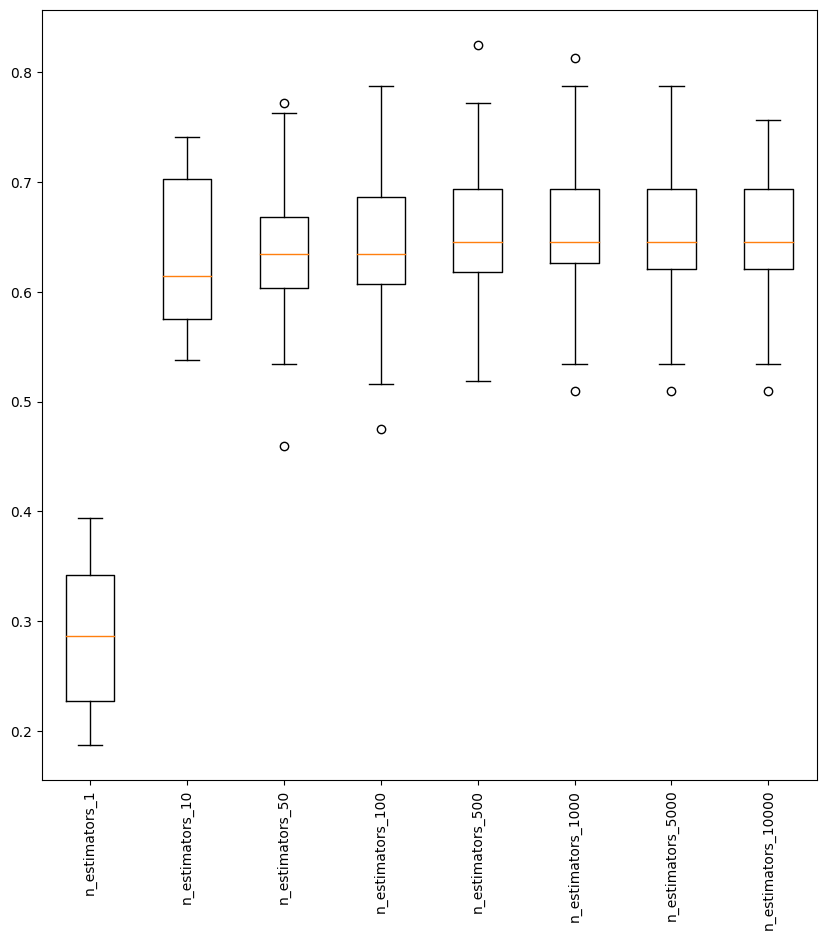

Balanced Accuracy (testing):0.75
                                  precision    recall  f1-score   support

                     Bottle caps       0.33      0.50      0.40         2
                  Cigarillo tips       0.00      0.00      0.00         1
               Fabric face masks       1.00      1.00      1.00         1
              Fishing bait trays       1.00      1.00      1.00         1
                 Food containers       0.50      1.00      0.67         1
                  Food packaging       0.50      1.00      0.67         1
                   Food wrappers       1.00      1.00      1.00         1
Mixed plastic waste (fragmented)       0.00      0.00      0.00         1
               Plastic Toy balls       1.00      1.00      1.00         1
                    Plastic cups       0.00      0.00      0.00         1
         Plastic drinking straws       1.00      1.00      1.00         2
          Polystyrene food waste       1.00      1.00      1.00         1
    

C:\Users\huyng\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\huyng\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\huyng\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


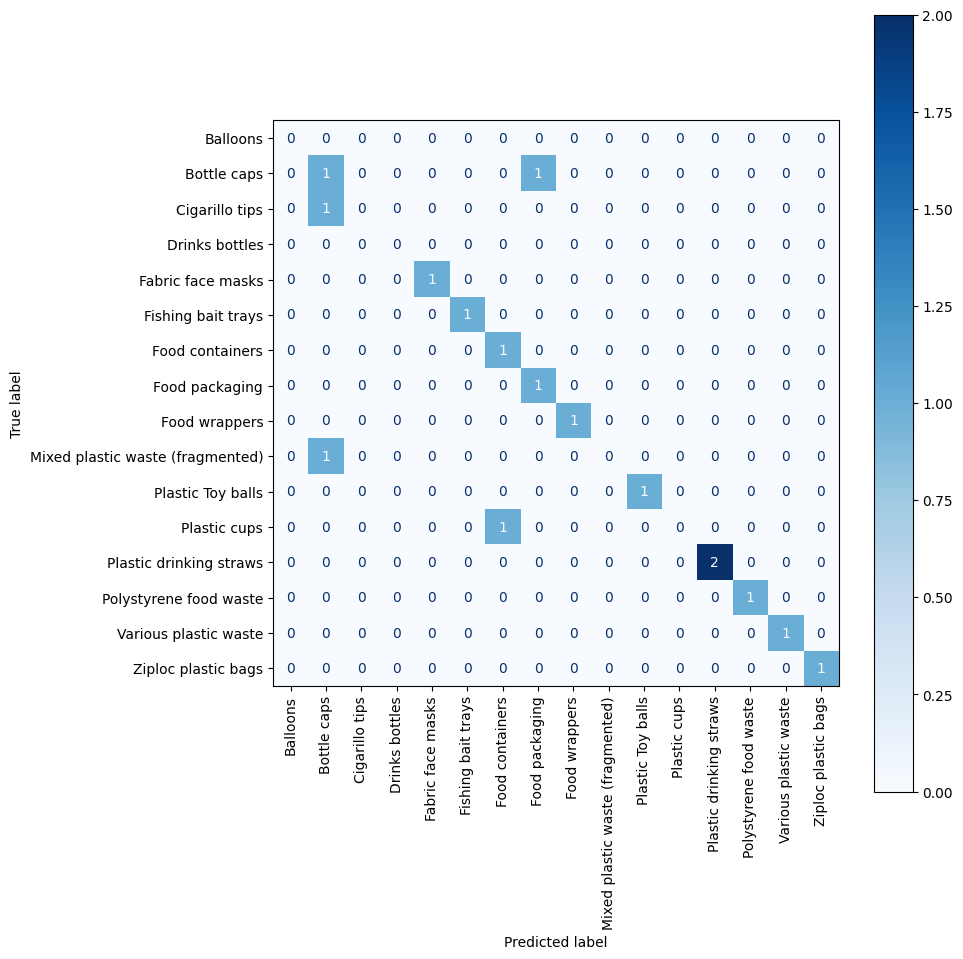

In [43]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

param_grid = {
'n_estimators':  [1, 10, 50, 100, 500, 1000, 5000, 10000], # Generate an array of 100 stepwise values from 0 to 1000, 
}

# # The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf) 
unique, counts = np.unique(y_train, return_counts=True)
min_count_idx = np.argmin(counts)

cv = RepeatedStratifiedKFold(n_splits = counts[min_count_idx], n_repeats = 10, random_state = 123)

gridsearch = GridSearchCV(XGBClassifier(), param_grid=param_grid, 
                        # number of cv = number of member of classes with least no. of members
                        cv = cv,  
                        scoring = 'balanced_accuracy',
                        n_jobs = -1, return_train_score = True,
                         ).fit(X_train, y_train_encoded)

grid = gridsearch.best_params_
print(grid)

# Monitoring split_test_score across different hyperparameters of GridSearch -------------------------------------------------------
glued_dicts = ['_'.join([f"{key}_{value}" for key, value in d.items()]) for d in gridsearch.cv_results_['params']]
split_test_scores_list = []

# Iterate over each row
for index, row in pd.DataFrame(gridsearch.cv_results_).iterrows():
    split_test_scores = []
    # Iterate over each column
    for column in pd.DataFrame(gridsearch.cv_results_).columns:
        # Check if column name matches the pattern "splitx_test_score"
        if column.startswith('split') and column.endswith('_test_score'):
            # Extract numerical value from the column
            split_test_score = row[column]
            split_test_scores.append(split_test_score)
    split_test_scores_list.append(split_test_scores)

for name, scores in zip(glued_dicts, split_test_scores_list):
  # summarize progress along the way
 print('%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(split_test_scores_list, labels=glued_dicts, showbox=True, showfliers=True, showcaps=True)
plt.xticks(rotation=90)
plt.show()

# Train model with best params ---------------------------------------
gbm_model = XGBClassifier(n_estimators= grid['n_estimators'])
gbm_model.fit(X_train, y_train_encoded)

predictions_test = gbm_model.predict_proba(X_test)
pred_df_test = pd.DataFrame(predictions_test, columns=gbm_model.classes_)

y_pred_test = label_encoder.inverse_transform(pred_df_test.select_dtypes(include=[np.number]).idxmax(axis=1))
label_encoder.inverse_transform(gbm_model.classes_)

# Balanced accuracy score
print("Balanced Accuracy (testing):" + str(balanced_accuracy_score(y_test, y_pred_test)))

# Generate confusion matrix of test set
conf_matrix_sklearn = confusion_matrix(y_test, y_pred_test, labels=label_encoder.inverse_transform(gbm_model.classes_))

print(classification_report(y_test, y_pred_test))

# To visualize the confusion matrix
ConfusionMatrixDisplay(conf_matrix_sklearn,
                      display_labels=label_encoder.inverse_transform(gbm_model.classes_)).plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.tight_layout()
plt.show()

#### LightGBM <a class="anchor" id="lightgbm"></a>

Accuracy: 0.569 (0.067)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7989
[LightGBM] [Info] Number of data points in the train set: 109, number of used features: 643
[LightGBM] [Info] Start training from score -3.592736
[LightGBM] [Info] Start training from score -2.388763
[LightGBM] [Info] Start training from score -2.611906
[LightGBM] [Info] Start training from score -3.592736
[LightGBM] [Info] Start training from score -2.611906
[LightGBM] [Info] Start training from score -2.611906
[LightGBM] [Info] Start training from score -2.494123
[LightGBM] [Info] Start training from score -2.611906
[LightGBM] [Info] Start training from score -2.611906
[LightGBM] [Info] Start training from score -3.998201
[LightGBM] [Info] Start training from score -2.611906
[LightGBM] [Info] Start training from score -3.998201
[LightGBM] [Info] Start training from sc

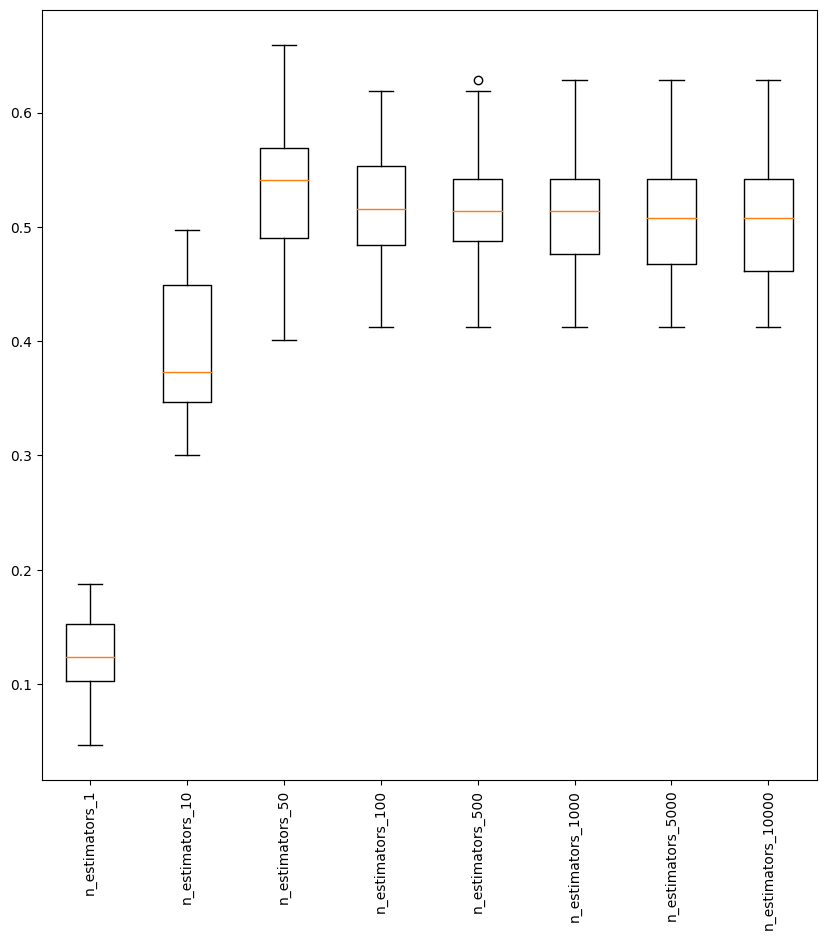

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7989
[LightGBM] [Info] Number of data points in the train set: 109, number of used features: 643
[LightGBM] [Info] Start training from score -3.592736
[LightGBM] [Info] Start training from score -2.388763
[LightGBM] [Info] Start training from score -2.611906
[LightGBM] [Info] Start training from score -3.592736
[LightGBM] [Info] Start training from score -2.611906
[LightGBM] [Info] Start training from score -2.611906
[LightGBM] [Info] Start training from score -2.494123
[LightGBM] [Info] Start training from score -2.611906
[LightGBM] [Info] Start training from score -2.611906
[LightGBM] [Info] Start training from score -3.998201
[LightGBM] [Info] Start training from score -2.611906
[LightGBM] [Info] Start training from score -3.998201
[LightGBM] [Info] Start training from score -2.494123
[LightGBM]

C:\Users\huyng\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\huyng\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\huyng\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\huyng\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

                                  precision    recall  f1-score   support

                        Balloons       0.00      0.00      0.00         0
                     Bottle caps       0.00      0.00      0.00         2
                  Cigarillo tips       0.00      0.00      0.00         1
               Fabric face masks       1.00      1.00      1.00         1
              Fishing bait trays       0.50      1.00      0.67         1
                 Food containers       0.50      1.00      0.67         1
                  Food packaging       1.00      1.00      1.00         1
                   Food wrappers       1.00      1.00      1.00         1
Mixed plastic waste (fragmented)       0.00      0.00      0.00         1
               Plastic Toy balls       1.00      1.00      1.00         1
                    Plastic cups       0.00      0.00      0.00         1
         Plastic drinking straws       0.67      1.00      0.80         2
          Polystyrene food waste     

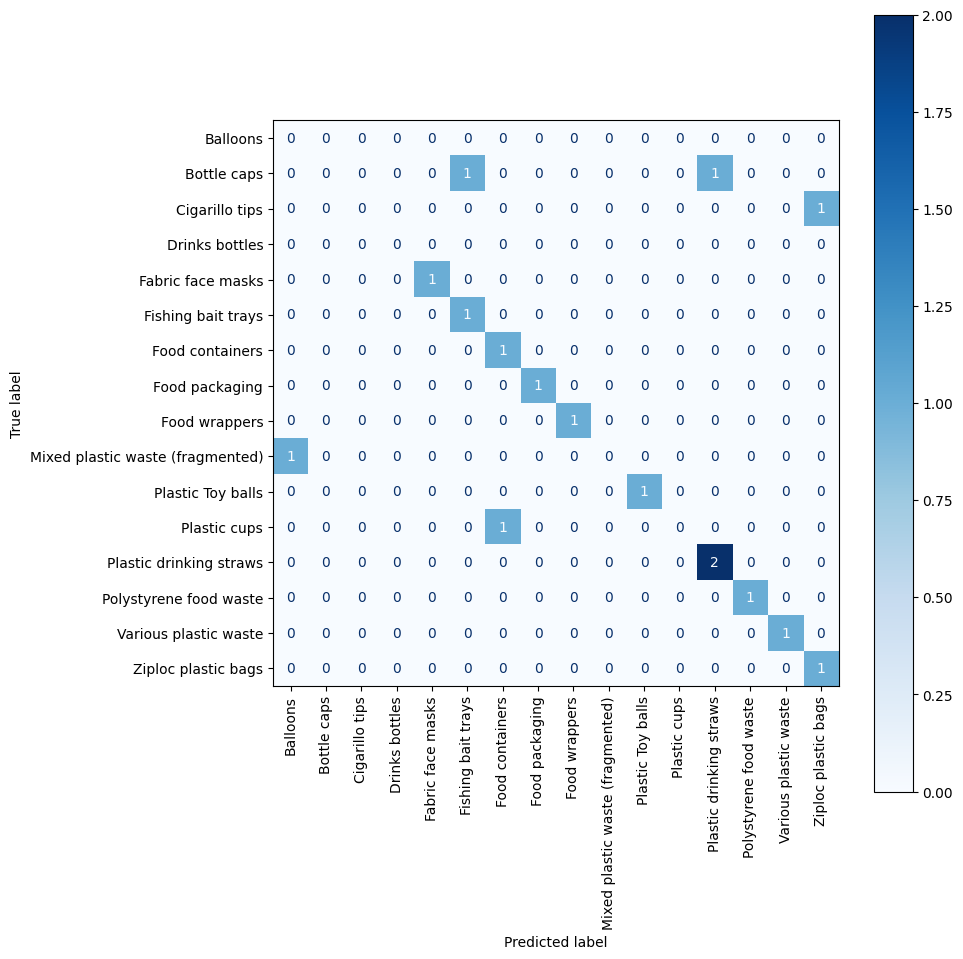

In [45]:
dat = gc_hplc_zero_reduc
# If a class only have 1 member then exclude that class from the ML
# Count the frequency of each class
class_counts = dat['Subcategory'].astype(str).value_counts()
# Filter out classes with only one member
dat = dat[dat['Subcategory'].astype(str).map(class_counts) > 1]

# Extract the features and labels
X = dat.drop(columns=['Subcategory'])
y = dat['Subcategory']

regex = re.compile(r"\[|\]|<|>| ", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<', '>', " "))) else col for col in X.columns.values]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = round(len(dat['Subcategory'].unique())/dat.shape[0], 3), 
                                                    stratify = y, 
                                                    random_state= 123 # random.randrange(999)
                                                   )

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

param_grid = {
'n_estimators':  [1, 10, 50, 100, 500, 1000, 5000, 10000], # Generate an array of 100 stepwise values from 0 to 1000, 
}

# # The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf) 
unique, counts = np.unique(y_train, return_counts=True)
min_count_idx = np.argmin(counts)

cv = RepeatedStratifiedKFold(n_splits = counts[min_count_idx], n_repeats = 10, random_state = 123)

gridsearch = GridSearchCV(LGBMClassifier(), param_grid=param_grid, 
                        # number of cv = number of member of classes with least no. of members
                        cv = cv,  
                        scoring = 'balanced_accuracy',
                        n_jobs = -1, return_train_score = True,
                         ).fit(X_train, y_train_encoded)

grid = gridsearch.best_params_

# Monitoring split_test_score across different hyperparameters of GridSearch -------------------------------------------------------
glued_dicts = ['_'.join([f"{key}_{value}" for key, value in d.items()]) for d in gridsearch.cv_results_['params']]
split_test_scores_list = []

# Iterate over each row
for index, row in pd.DataFrame(gridsearch.cv_results_).iterrows():
    split_test_scores = []
    # Iterate over each column
    for column in pd.DataFrame(gridsearch.cv_results_).columns:
        # Check if column name matches the pattern "splitx_test_score"
        if column.startswith('split') and column.endswith('_test_score'):
            # Extract numerical value from the column
            split_test_score = row[column]
            split_test_scores.append(split_test_score)
    split_test_scores_list.append(split_test_scores)

for name, scores in zip(glued_dicts, split_test_scores_list):
  # summarize progress along the way
 print('%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(split_test_scores_list, labels=glued_dicts, showbox=True, showfliers=True, showcaps=True)
plt.xticks(rotation=90)
plt.show()

# Train model with best params ---------------------------------------
gbm_model = LGBMClassifier(n_estimators= grid['n_estimators'])
gbm_model.fit(X_train, y_train_encoded)

predictions_test = gbm_model.predict_proba(X_test)
pred_df_test = pd.DataFrame(predictions_test, columns=gbm_model.classes_)

y_pred_test = label_encoder.inverse_transform(pred_df_test.select_dtypes(include=[np.number]).idxmax(axis=1))
label_encoder.inverse_transform(gbm_model.classes_)

# Balanced accuracy score
print("Balanced Accuracy (testing):" + str(balanced_accuracy_score(y_test, y_pred_test)))

# Generate confusion matrix of test set
conf_matrix_sklearn = confusion_matrix(y_test, y_pred_test, labels=label_encoder.inverse_transform(gbm_model.classes_))

print(classification_report(y_test, y_pred_test))

# To visualize the confusion matrix
ConfusionMatrixDisplay(conf_matrix_sklearn,
                      display_labels=label_encoder.inverse_transform(gbm_model.classes_)).plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.tight_layout()
plt.show()

#### CatBoost <a class="anchor" id="catboost"></a>

In [48]:
from catboost import CatBoostClassifier

In [ ]:
dat = hplc_zero_reduc
# If a class only have 1 member then exclude that class from the ML
# Count the frequency of each class
class_counts = dat['Subcategory'].astype(str).value_counts()
# Filter out classes with only one member
dat = dat[dat['Subcategory'].astype(str).map(class_counts) > 1]

# Extract the features and labels
X = dat.drop(columns=['Subcategory'])
y = dat['Subcategory']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = round(len(dat['Subcategory'].unique())/dat.shape[0], 3), 
                                                    stratify = y, 
                                                    random_state= 123 # random.randrange(999)
                                                   )

param_grid = {
'n_estimators':  [1, 10, 50, 100, 500, 1000, 5000, 10000], # Generate an array of 100 stepwise values from 0 to 1000, 
}

# The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf) 
unique, counts = np.unique(y_train, return_counts=True)
min_count_idx = np.argmin(counts)

cv = RepeatedStratifiedKFold(n_splits = counts[min_count_idx], n_repeats = 10, random_state = 123)

gridsearch = GridSearchCV(CatBoostClassifier(), param_grid=param_grid, 
                        # number of cv = number of member of classes with least no. of members
                        cv = cv,  
                        scoring = 'balanced_accuracy',
                        n_jobs = -1, return_train_score = True,
                         ).fit(X_train, y_train)

grid = gridsearch.best_params_

# Monitoring split_test_score across different hyperparameters of GridSearch -------------------------------------------------------
glued_dicts = ['_'.join([f"{key}_{value}" for key, value in d.items()]) for d in gridsearch.cv_results_['params']]
split_test_scores_list = []

# Iterate over each row
for index, row in pd.DataFrame(gridsearch.cv_results_).iterrows():
    split_test_scores = []
    # Iterate over each column
    for column in pd.DataFrame(gridsearch.cv_results_).columns:
        # Check if column name matches the pattern "splitx_test_score"
        if column.startswith('split') and column.endswith('_test_score'):
            # Extract numerical value from the column
            split_test_score = row[column]
            split_test_scores.append(split_test_score)
    split_test_scores_list.append(split_test_scores)

for name, scores in zip(glued_dicts, split_test_scores_list):
  # summarize progress along the way
 print('%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(split_test_scores_list, labels=glued_dicts, showbox=True, showfliers=True, showcaps=True)
plt.xticks(rotation=90)
plt.show()

# Train model with best params ---------------------------------------
gbm_model = CatBoostClassifier(n_estimators= grid['n_estimators'])
gbm_model.fit(X_train, y_train)

predictions_test = gbm_model.predict_proba(X_test)
y_pred_test = pd.DataFrame(predictions_test, columns=gbm_model.classes_).select_dtypes(include=[np.number]).idxmax(axis=1)

# Balanced accuracy score
print("Balanced Accuracy (testing):" + str(balanced_accuracy_score(y_test, y_pred_test)))

# Generate confusion matrix of test set
conf_matrix_sklearn = confusion_matrix(y_test, y_pred_test, labels=gbm_model.classes_)

print(classification_report(y_test, y_pred_test))

# To visualize the confusion matrix
ConfusionMatrixDisplay(conf_matrix_sklearn,
                      display_labels=gbm_model.classes_).plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.tight_layout()
plt.show()

#### Histogram-Based Gradient Boosting <a class="anchor" id="histgbm"></a>

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
dat = gc_hplc_zero_reduc
# If a class only have 1 member then exclude that class from the ML
# Count the frequency of each class
class_counts = dat['Subcategory'].astype(str).value_counts()
# Filter out classes with only one member
dat = dat[dat['Subcategory'].astype(str).map(class_counts) > 1]

# Extract the features and labels
X = dat.drop(columns=['Subcategory'])
y = dat['Subcategory']

regex = re.compile(r"\[|\]|<|>| ", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<', '>', " "))) else col for col in X.columns.values]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = round(len(dat['Subcategory'].unique())/dat.shape[0], 3), 
                                                    stratify = y, 
                                                    random_state= 123 # random.randrange(999)
                                                   )

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

param_grid = {
'learning_rate':  [0.0001, 0.001, 0.01, 0.1, 0.5], # Generate an array of 100 stepwise values from 0 to 1000, 
}

# # The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf) 
unique, counts = np.unique(y_train, return_counts=True)
min_count_idx = np.argmin(counts)

cv = RepeatedStratifiedKFold(n_splits = counts[min_count_idx], n_repeats = 10, random_state = 123)

gridsearch = GridSearchCV(HistGradientBoostingClassifier(), param_grid=param_grid, 
                        # number of cv = number of member of classes with least no. of members
                        cv = cv,  
                        scoring = 'balanced_accuracy',
                        n_jobs = -1, return_train_score = True,
                         ).fit(X_train, y_train_encoded)

grid = gridsearch.best_params_

# Monitoring split_test_score across different hyperparameters of GridSearch -------------------------------------------------------
glued_dicts = ['_'.join([f"{key}_{value}" for key, value in d.items()]) for d in gridsearch.cv_results_['params']]
split_test_scores_list = []

# Iterate over each row
for index, row in pd.DataFrame(gridsearch.cv_results_).iterrows():
    split_test_scores = []
    # Iterate over each column
    for column in pd.DataFrame(gridsearch.cv_results_).columns:
        # Check if column name matches the pattern "splitx_test_score"
        if column.startswith('split') and column.endswith('_test_score'):
            # Extract numerical value from the column
            split_test_score = row[column]
            split_test_scores.append(split_test_score)
    split_test_scores_list.append(split_test_scores)

for name, scores in zip(glued_dicts, split_test_scores_list):
  # summarize progress along the way
 print('%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(split_test_scores_list, labels=glued_dicts, showbox=True, showfliers=True, showcaps=True)
plt.xticks(rotation=90)
plt.show()

# Train model with best params ---------------------------------------
gbm_model = HistGradientBoostingClassifier(n_estimators= grid['learning_rate'])
gbm_model.fit(X_train, y_train_encoded)

predictions_test = gbm_model.predict_proba(X_test)
pred_df_test = pd.DataFrame(predictions_test, columns=gbm_model.classes_)

y_pred_test = label_encoder.inverse_transform(pred_df_test.select_dtypes(include=[np.number]).idxmax(axis=1))
label_encoder.inverse_transform(gbm_model.classes_)

# Balanced accuracy score
print("Balanced Accuracy (testing):" + str(balanced_accuracy_score(y_test, y_pred_test)))

# Generate confusion matrix of test set
conf_matrix_sklearn = confusion_matrix(y_test, y_pred_test, labels=label_encoder.inverse_transform(gbm_model.classes_))

print(classification_report(y_test, y_pred_test))

# To visualize the confusion matrix
ConfusionMatrixDisplay(conf_matrix_sklearn,
                      display_labels=label_encoder.inverse_transform(gbm_model.classes_)).plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.tight_layout()
plt.show()

#### GBM <a class="anchor" id="gbm"></a>

In [ ]:
def gbm_result(dat,
               type):
    
    # If a class only have 1 member then exclude that class from the ML
    # Count the frequency of each class
    class_counts = dat[type].astype(str).value_counts()
    # Filter out classes with only one member
    dat = dat[dat[type].astype(str).map(class_counts) > 1]
    
    # Extract the features and labels
    X = dat.drop(columns=[type])
    y = dat[type]
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = round(len(dat[type].unique())/dat.shape[0], 2), 
                                                        stratify = y, 
                                                        random_state= 123 # random.randrange(999)
                                                       )

    param_grid = {
    'n_estimators':  [1, 10, 50, 100, 500, 1000, 5000, 10000], # Generate an array of 100 stepwise values from 0 to 1000, 
    'max_features': ['sqrt', 'log2']
    }

    # The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf) 
    cv = RepeatedStratifiedKFold(n_splits = pd.DataFrame(y_train)[type].value_counts().min(),
                                 n_repeats = 10, random_state = 123)
    if pd.DataFrame(y_train)[type].value_counts().min() == 1:
        cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 10, random_state = 123)
    
    gridsearch = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, 
                            # number of cv = number of member of classes with least no. of members
                            cv = cv,  
                            scoring = 'balanced_accuracy',
                            n_jobs = -1, return_train_score = True,
                             ).fit(X_train, y_train)
    grid = gridsearch.best_params_
    
    # Monitoring split_test_score across different hyperparameters of GridSearch -------------------------------------------------------
    glued_dicts = ['_'.join([f"{key}_{value}" for key, value in d.items()]) for d in gridsearch.cv_results_['params']]
    split_test_scores_list = []
    
    # Iterate over each row
    for index, row in pd.DataFrame(gridsearch.cv_results_).iterrows():
        split_test_scores = []
        # Iterate over each column
        for column in pd.DataFrame(gridsearch.cv_results_).columns:
            # Check if column name matches the pattern "splitx_test_score"
            if column.startswith('split') and column.endswith('_test_score'):
                # Extract numerical value from the column
                split_test_score = row[column]
                split_test_scores.append(split_test_score)
        split_test_scores_list.append(split_test_scores)
    
    for name, scores in zip(glued_dicts, split_test_scores_list):
      # summarize progress along the way
     print('%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    # plot model performance for comparison
    plt.boxplot(split_test_scores_list, labels=glued_dicts, showbox=True, showfliers=True, showcaps=True)
    plt.xticks(rotation=90)
    plt.show()

    # Train the model
    gbm_model = GradientBoostingClassifier(n_estimators= grid['n_estimators'], max_features= grid['max_features'], 
                                           random_state= 123, # random.randrange(999), 
                                           max_depth = None, criterion= "friedman_mse")
    gbm_model.fit(X_train, y_train)
    
    # Prediction results
    # For test set
    predictions_test = gbm_model.predict_proba(X_test)
    pred_df_test = pd.DataFrame(predictions_test, columns=gbm_model.classes_)
      
    # Assign true and predicted labels
    # For test set
    y_true_test = y_test
    y_pred_test = pred_df_test.select_dtypes(include=[np.number]).idxmax(axis=1)
    
    # Balanced accuracy score
    print("Balanced Accuracy (testing):" + str(balanced_accuracy_score(y_true_test, y_pred_test)))
    
    # Generate confusion matrix of test set
    conf_matrix_sklearn = confusion_matrix(y_true_test, y_pred_test, labels=gbm_model.classes_)
    
    print(classification_report(y_true_test, y_pred_test))
    
    # To visualize the confusion matrix
    ConfusionMatrixDisplay(conf_matrix_sklearn,
                          display_labels=gbm_model.classes_).plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.tight_layout()
    plt.show()

    # Histogram of distribution of probability of each class in prediction
    for column in pred_df_test.columns:
        # Create a histogram for the current column
        plt.hist(pred_df_test[column], bins=10, alpha=0.5, label=column)
        # Round up y-axis ticks to have no decimals
        plt.yticks(np.arange(plt.yticks()[0][0], plt.yticks()[0][-1] + 1, step=1))
        
        # Add title for each subplot as the name of the column
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
        
    # Plot feature importance
    # feature importance scores will be in the range [0,1]. 
    # Higher scores mean the feature is more important. This is an array with shape (n_features,) whose values are positive and sum to 1.0
    feature_imp = pd.DataFrame({'feature_score': gbm_model.feature_importances_, 
                             'feature_name': dat.drop(columns=[type]).columns}).sort_values('feature_score')
    
    # Plot the top 25 most important features
    plt.barh(range(25), feature_imp.tail(n = 25).feature_score)
    plt.yticks(range(25), feature_imp.tail(n = 25).feature_name)
    plt.xlabel('Importance')
    plt.title('Variable Importance')
    plt.show()
    
    return gbm_model, feature_imp

#### Classification by Category

##### GC data

In [ ]:
# zero
for i in range(4):
    clf = gbm_result(gc_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = gbm_result(gc_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = gbm_result(gc_cat_lod[i],
                       type = 'Category')

##### HPLC data

In [ ]:
# zero
for i in range(4):
    clf = gbm_result(hplc_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = gbm_result(hplc_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = gbm_result(hplc_cat_lod[i],
                       type = 'Category')

##### ICP data

In [ ]:
for i in range(4):
    clf = gbm_result(icp_cat[i],
                       type = 'Category')

##### GC + ICP

In [ ]:
# zero
for i in range(4):
    clf = gbm_result(gc_icp_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = gbm_result(gc_icp_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = gbm_result(gc_icp_cat_lod[i],
                       type = 'Category')

##### HPLC + ICP

In [ ]:
# zero
for i in range(4):
    clf = gbm_result(hplc_icp_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = gbm_result(hplc_icp_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = gbm_result(hplc_icp_cat_lod[i],
                       type = 'Category')

##### GC + HPLC data

In [ ]:
# zero
for i in range(4):
    clf = gbm_result(gc_hplc_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = gbm_result(gc_hplc_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = gbm_result(gc_hplc_cat_lod[i],
                       type = 'Category')

##### GC + HPLC + ICP data

In [ ]:
# zero
for i in range(4):
    clf = gbm_result(gc_hplc_icp_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = gbm_result(gc_hplc_icp_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = gbm_result(gc_hplc_icp_cat_lod[i],
                       type = 'Category')

##### GC data

In [ ]:
for i in range(4):
    dat_in = pre_ml_processing(gc_list,
                                    # sig_comp_list = significant_comp, 
                               type = 'Category',
                                list_ele=i)
    clf = gbm_result(dat_in,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        split_train = 0.5)

##### HPLC data

In [ ]:
for i in range(4):
    dat_in = pre_ml_processing(hplc_list,
                                    # sig_comp_list = significant_comp, 
                               type = 'Category',
                                list_ele=i)
    clf = gbm_result(dat_in,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category', 
                        split_train = 0.5)

##### ICP data

In [ ]:
for i in range(4):
    dat_in = pre_ml_processing(icp_list,
                                    # sig_comp_list = significant_comp, 
                               type = 'Category',
                                list_ele=i)
    
    clf = gbm_result(icp_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        split_train = 0.5)

##### GC + ICP

In [ ]:
for i in range(4):
    clf = gbm_result(gc_icp_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### HPLC + ICP

In [ ]:
for i in range(4):
    clf = gbm_result(hplc_icp_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### GC + HPLC data

In [ ]:
for i in range(4):
    clf = gbm_result(gc_hplc_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### GC + HPLC + ICP data

In [ ]:
for i in range(4):
    clf = gbm_result(gc_hplc_icp_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

#### Classification By Subcategory

##### GC data

In [ ]:
clf, gbm_topfeature = gbm_result(gc_zero_USE.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
toprf = rf_topfeature.sort_values(by='feature_score', ascending=False).head(10)['feature_name']
topgbm = gbm_topfeature.sort_values(by='feature_score', ascending=False).head(10)['feature_name']

toprf_gbm = list(set(toprf) | set(topgbm))

pd.DataFrame(toprf_gbm).to_csv('toprf_gbm.csv', index=False, header=False)

In [ ]:
# Zero
clf = gbm_result(gc_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = gbm_result(gc_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = gbm_result(gc_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### HPLC data

In [ ]:
# Zero
clf, gbm_topfeature = gbm_result(hplc_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = gbm_result(hplc_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = gbm_result(hplc_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### ICP data

In [ ]:
clf = gbm_result(icp_all,
                   type = 'Subcategory')

##### GC + ICP

In [ ]:
# Zero
clf = gbm_result(gc_icp_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = gbm_result(gc_icp_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = gbm_result(gc_icp_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### HPLC + ICP

In [ ]:
# Zero
clf = gbm_result(hplc_icp_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = gbm_result(hplc_icp_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = gbm_result(hplc_icp_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### GC + HPLC data

In [ ]:
# Zero
clf = gbm_result(gc_hplc_zero.drop(columns=['technique']), 
                   type = 'Subcategory')

In [ ]:
# Min
clf = gbm_result(gc_hplc_min.drop(columns=['technique']), 
                   type = 'Subcategory')

In [ ]:
# LOD
clf = gbm_result(gc_hplc_lod.drop(columns=['technique']), 
                   type = 'Subcategory')

##### GC + HPLC + ICP data

In [ ]:
# Zero
clf = gbm_result(gc_hplc_icp_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = gbm_result(gc_hplc_icp_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = gbm_result(gc_hplc_icp_lod.drop(columns=['technique']),
                   type = 'Subcategory')

### Supported Vector Machine <a class="anchor" id="svm"></a>

In [ ]:
def f_importances(coef, names, ntop = 25):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    # take top n positive and top n negative effect features
    topimp = imp[:ntop] + imp[-ntop:]
    topnames = names[:ntop] + names[-ntop:]
    plt.barh(range(len(topnames)), topimp, align='center')
    plt.yticks(range(len(topnames)), topnames)
    plt.show()
        
def SVM_res(dat,
            type):
               
    # If a class only have 1 member then exclude that class from the ML
    # Count the frequency of each class
    class_counts = dat[type].astype(str).value_counts()
    # Filter out classes with only one member
    dat = dat[dat[type].astype(str).map(class_counts) > 1]
    
    # Extract the features and labels
    X = dat.drop(columns=[type])
    y = dat[type]
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = round(len(dat[type].unique())/dat.shape[0], 2), 
                                                        stratify = y, 
                                                        random_state= 123
                                                       )
        
    # Create the parameter grid based on the results of random search 
    param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000], 
                  'kernel': ['linear', 'poly', 'sigmoid', 'rbf'], 'degree': [3, 4, 5, 6]}

    # The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf) 
    cv = RepeatedStratifiedKFold(n_splits = pd.DataFrame(y_train)[type].value_counts().min(),
                                 n_repeats = 10, random_state = 123)
    if pd.DataFrame(y_train)[type].value_counts().min() == 1:
        cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 10, random_state = 123)
        
    # Create a GridSearchCV object and fit it to the training data
    gridsearch = GridSearchCV(SVC(probability=True), param_grid=param_grid, 
                                  # number of cv = number of member of classes with least no. of members
                                  cv = cv, 
                                  scoring = 'balanced_accuracy',
                                return_train_score = True,
                                  n_jobs = -1).fit(X_train, y_train)
    svm_grid = gridsearch.best_params_
    svm_grid
        
    # Monitoring split_test_score across different hyperparameters of GridSearch -------------------------------------------------------
    glued_dicts = ['_'.join([f"{key}_{value}" for key, value in d.items()]) for d in gridsearch.cv_results_['params']]
    split_test_scores_list = []
    
    # Iterate over each row
    for index, row in pd.DataFrame(gridsearch.cv_results_).iterrows():
        split_test_scores = []
        # Iterate over each column
        for column in pd.DataFrame(gridsearch.cv_results_).columns:
            # Check if column name matches the pattern "splitx_test_score"
            if column.startswith('split') and column.endswith('_test_score'):
                # Extract numerical value from the column
                split_test_score = row[column]
                split_test_scores.append(split_test_score)
        split_test_scores_list.append(split_test_scores)
    
    for name, scores in zip(glued_dicts, split_test_scores_list):
      # summarize progress along the way
     print('%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    # plot model performance for comparison
    plt.boxplot(split_test_scores_list, labels=glued_dicts, showbox=True, showfliers=True, showcaps=True)
    plt.xticks(rotation=90)
    plt.show()
    
    # Train the model
    svm_best = SVC(kernel = svm_grid['kernel'], degree = svm_grid['degree'], C=svm_grid['C'], probability = True)
    svm_best.fit(X_train, y_train)
   
    # Prediction results
    # For test set
    predictions_test = svm_best.predict_proba(X_test)
    pred_df_test = pd.DataFrame(predictions_test, columns=svm_best.classes_)
       
    # Assign true and predicted labels
    # For test set
    y_true_test = y_test
    y_pred_test = pred_df_test.select_dtypes(include=[np.number]).idxmax(axis=1)
    
    # Balanced accuracy score
    print("Balanced Accuracy (testing):" + str(balanced_accuracy_score(y_true_test, y_pred_test)))
    
    # Generate confusion matrix
    conf_matrix_sklearn = confusion_matrix(y_true_test, y_pred_test, labels=svm_best.classes_)
    
    print(classification_report(y_true_test, y_pred_test))
    
    # To visualize the confusion matrix
    ConfusionMatrixDisplay(conf_matrix_sklearn,
                          display_labels=svm_best.classes_).plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.tight_layout()
    plt.show()

    # Histogram of distribution of probability of each class in prediction
    for column in pred_df_test.columns:
        # Create a histogram for the current column
        plt.hist(pred_df_test[column], bins=10, alpha=0.5, label=column)
        # Round up y-axis ticks to have no decimals
        plt.yticks(np.arange(plt.yticks()[0][0], plt.yticks()[0][-1] + 1, step=1))
        
        # Add title for each subplot as the name of the column
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
        
    # Compute permutation importance if kernel = 'rbf'
    perimp = permutation_importance(svm_best, X_test, y_test, 
                                    n_repeats=1, random_state=42, n_jobs = -1).importances_mean
        
    # Extract important features if kernel = 'linear'
    features_names = list(X_train.columns) 
    f_importances(perimp,
    #         permutation_importance(svm_best, X_test, y_test, 
    #                                          n_repeats=5, random_state=42, n_jobs = -1).importances_mean,
                  features_names)
    return svm_best

#### Classification by Category

##### GC data

In [ ]:
# zero
for i in range(4):
    clf = SVM_res(gc_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = SVM_res(gc_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = SVM_res(gc_cat_lod[i],
                       type = 'Category')

##### HPLC data

In [ ]:
# zero
for i in range(4):
    clf = SVM_res(hplc_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = SVM_res(hplc_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = SVM_res(hplc_cat_lod[i],
                       type = 'Category')

##### ICP data

In [ ]:
for i in range(4):
    clf = SVM_res(icp_cat[i],
                       type = 'Category')

##### GC + ICP

In [ ]:
# zero
for i in range(4):
    clf = SVM_res(gc_icp_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = SVM_res(gc_icp_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = SVM_res(gc_icp_cat_lod[i],
                       type = 'Category')

##### HPLC + ICP

In [ ]:
# zero
for i in range(4):
    clf = SVM_res(hplc_icp_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = SVM_res(hplc_icp_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = SVM_res(hplc_icp_cat_lod[i],
                       type = 'Category')

##### GC + HPLC data

In [ ]:
# zero
for i in range(4):
    clf = SVM_res(gc_hplc_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = SVM_res(gc_hplc_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = SVM_res(gc_hplc_cat_lod[i],
                       type = 'Category')

##### GC + HPLC + ICP data

In [ ]:
# zero
for i in range(4):
    clf = SVM_res(gc_hplc_icp_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = SVM_res(gc_hplc_icp_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = SVM_res(gc_hplc_icp_cat_lod[i],
                       type = 'Category')

##### GC data

In [ ]:
for i in range(4):
    clf = SVM_res(gc_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### HPLC data

In [ ]:
for i in range(4):
    clf = SVM_res(hplc_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### ICP data

In [ ]:
for i in range(4):
    clf = SVM_res(icp_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### GC + ICP

In [ ]:
for i in range(4):
    clf = SVM_res(gc_icp_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### HPLC + ICP

In [ ]:
for i in range(4):
    clf = SVM_res(hplc_icp_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### GC + HPLC data

In [ ]:
for i in range(4):
    clf = SVM_res(gc_hplc_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### GC + HPLC + ICP data

In [ ]:
for i in range(4):
    clf = SVM_res(gc_hplc_icp_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

#### Classification By Subcategory

##### GC data

In [ ]:
# Zero
clf = SVM_res(gc_zero.drop(columns=['technique']), 
            type = 'Subcategory')

In [ ]:
# Min
clf = SVM_res(gc_min.drop(columns=['technique']), 
            type = 'Subcategory')

In [ ]:
# LOD
clf = SVM_res(gc_lod.drop(columns=['technique']), 
            type = 'Subcategory')

##### HPLC data

In [ ]:
# Zero
clf = SVM_res(hplc_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = SVM_res(hplc_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = SVM_res(hplc_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### ICP data

In [ ]:
clf = SVM_res(icp_all,
                   type = 'Subcategory')

##### GC + ICP

In [ ]:
# Zero
clf = SVM_res(gc_icp_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = SVM_res(gc_icp_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = SVM_res(gc_icp_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### HPLC + ICP

In [ ]:
# Zero
clf = SVM_res(hplc_icp_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = SVM_res(hplc_icp_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = SVM_res(hplc_icp_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### GC + HPLC data

In [ ]:
# Zero
clf = SVM_res(gc_hplc_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = SVM_res(gc_hplc_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = SVM_res(gc_hplc_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### GC + HPLC + ICP data

In [ ]:
# Zero
clf = SVM_res(gc_hplc_icp_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = SVM_res(gc_hplc_icp_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = SVM_res(gc_hplc_icp_lod.drop(columns=['technique']),
                   type = 'Subcategory')

### Penalized Multinomial Logistic Regression in Python <a class="anchor" id="multinom"></a>

In [ ]:
def caret_multinomlog_result(dat,
                             type):
               
    # If a class only have 1 member then exclude that class from the ML
    # Count the frequency of each class
    class_counts = dat[type].astype(str).value_counts()
    # Filter out classes with only one member
    dat = dat[dat[type].astype(str).map(class_counts) > 1]
    
    # Extract the features and labels
    X = dat.drop(columns=[type])
    y = dat[type]
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = round(len(dat[type].unique())/dat.shape[0], 2), 
                                                        stratify = y, 
                                                        random_state= 123
                                                       )

    # Standardizing the features (important for logistic regression)
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)

    # The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf) 
    cv = RepeatedStratifiedKFold(n_splits = pd.DataFrame(y_train)[type].value_counts().min(),
                                 n_repeats = 10, random_state = 123)
    if pd.DataFrame(y_train)[type].value_counts().min() == 1:
        cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 10, random_state = 123)
        
    # Grid search with 5-fold cross validation for best model parameters
    param_grid = {
    'C':  [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], # Generate an array of stepwise values 
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'multi_class': ['auto', 'ovr', 'multinomial']
    }
    
    gridsearch = GridSearchCV(LogisticRegression(), param_grid=param_grid, 
                                       # number of cv = number of member of classes with least no. of members
                                       cv = cv, 
                                       return_train_score = True,
                                       scoring = 'balanced_accuracy', n_jobs = -1).fit(X_train, y_train)
    multinom_grid = gridsearch.best_params_
    multinom_grid
    
    # Monitoring split_test_score across different hyperparameters of GridSearch -------------------------------------------------------
    glued_dicts = ['_'.join([f"{key}_{value}" for key, value in d.items()]) for d in gridsearch.cv_results_['params']]
    split_test_scores_list = []
    
    # Iterate over each row
    for index, row in pd.DataFrame(gridsearch.cv_results_).iterrows():
        split_test_scores = []
        # Iterate over each column
        for column in pd.DataFrame(gridsearch.cv_results_).columns:
            # Check if column name matches the pattern "splitx_test_score"
            if column.startswith('split') and column.endswith('_test_score'):
                # Extract numerical value from the column
                split_test_score = row[column]
                split_test_scores.append(split_test_score)
        split_test_scores_list.append(split_test_scores)
    
    for name, scores in zip(glued_dicts, split_test_scores_list):
      # summarize progress along the way
     print('%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    # plot model performance for comparison
    plt.boxplot(split_test_scores_list, labels=glued_dicts, showbox=True, showfliers=True, showcaps=True)
    plt.xticks(rotation=90)
    plt.show()
    
    # Training the final model after Cross-Validation grid search
    multinomlog_mod = LogisticRegression(solver = multinom_grid['solver'],  penalty = multinom_grid['penalty'], random_state=123,
                                         multi_class = multinom_grid['multi_class'], C = multinom_grid['C'], max_iter=10000, n_jobs=-1)

    # Fitting the model to the whole training data
    multinomlog_mod.fit(X_train, y_train)

    # Prediction results   
    # For test set
    predictions_test = multinomlog_mod.predict_proba(X_test)
    pred_df_test = pd.DataFrame(predictions_test, columns=multinomlog_mod.classes_)
    
    # Assign true and predicted labels
    y_true_test = y_test
    y_pred_test = pred_df_test.select_dtypes(include=[np.number]).idxmax(axis=1)
    
    # Balanced accuracy score
    print("Balanced Accuracy (testing) :" + str(balanced_accuracy_score(y_true_test, y_pred_test)))
    
    # Generate confusion matrix
    conf_matrix_sklearn = confusion_matrix(y_true_test, y_pred_test, labels=multinomlog_mod.classes_)

    # For a more detailed output similar to R's caret package
    print(classification_report(y_true_test, y_pred_test))

    # To visualize the confusion matrix
    ConfusionMatrixDisplay(conf_matrix_sklearn,
                          display_labels=multinomlog_mod.classes_).plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.tight_layout()
    plt.show()

    # Histogram of distribution of probability of each class in prediction
    for column in pred_df_test.columns:
        # Create a histogram for the current column
        plt.hist(pred_df_test[column], bins=10, alpha=0.5, label=column)
        # Round up y-axis ticks to have no decimals
        plt.yticks(np.arange(plt.yticks()[0][0], plt.yticks()[0][-1] + 1, step=1))
        
        # Add title for each subplot as the name of the column
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
        
    # Plot feature importance
    features_names = list(X_train.columns) 
    f_importances(multinomlog_mod.coef_[0],
                  features_names)  
    return multinomlog_mod

#### Classification by Category

##### GC data

In [ ]:
# zero
for i in range(4):
    clf = caret_multinomlog_result(gc_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = caret_multinomlog_result(gc_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = caret_multinomlog_result(gc_cat_lod[i],
                       type = 'Category')

##### HPLC data

In [ ]:
# zero
for i in range(4):
    clf = caret_multinomlog_result(hplc_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = caret_multinomlog_result(hplc_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = caret_multinomlog_result(hplc_cat_lod[i],
                       type = 'Category')

##### ICP data

In [ ]:
for i in range(4):
    clf = caret_multinomlog_result(icp_cat[i],
                       type = 'Category')

##### GC + ICP

In [ ]:
# zero
for i in range(4):
    clf = caret_multinomlog_result(gc_icp_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = caret_multinomlog_result(gc_icp_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = caret_multinomlog_result(gc_icp_cat_lod[i],
                       type = 'Category')

##### HPLC + ICP

In [ ]:
# zero
for i in range(4):
    clf = caret_multinomlog_result(hplc_icp_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = caret_multinomlog_result(hplc_icp_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = caret_multinomlog_result(hplc_icp_cat_lod[i],
                       type = 'Category')

##### GC + HPLC data

In [ ]:
# zero
for i in range(4):
    clf = caret_multinomlog_result(gc_hplc_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = caret_multinomlog_result(gc_hplc_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = caret_multinomlog_result(gc_hplc_cat_lod[i],
                       type = 'Category')

##### GC + HPLC + ICP data

In [ ]:
# zero
for i in range(4):
    clf = caret_multinomlog_result(gc_hplc_icp_cat_zero[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = caret_multinomlog_result(gc_hplc_icp_cat_min[i],
                       type = 'Category')

In [ ]:
# Min
for i in range(4):
    clf = caret_multinomlog_result(gc_hplc_icp_cat_lod[i],
                       type = 'Category')

##### GC data

In [ ]:
for i in range(4):
    clf = caret_multinomlog_result(gc_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### HPLC data

In [ ]:
for i in range(4):
    clf = caret_multinomlog_result(hplc_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### ICP data

In [ ]:
for i in range(4):
    clf = caret_multinomlog_result(icp_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### GC + ICP

In [ ]:
for i in range(4):
    clf = caret_multinomlog_result(gc_icp_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### HPLC + ICP

In [ ]:
for i in range(4):
    clf = caret_multinomlog_result(hplc_icp_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### GC + HPLC data

In [ ]:
for i in range(4):
    clf = caret_multinomlog_result(gc_hplc_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

##### GC + HPLC + ICP data

In [ ]:
for i in range(4):
    clf = caret_multinomlog_result(gc_hplc_icp_list,
                                    # sig_comp_list = significant_comp, 
                       type = 'Category',
                        list_ele=i, 
                        split_train = 0.5)

#### Classification By Subcategory

##### GC data

In [ ]:
# Zero
clf = caret_multinomlog_result(gc_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = caret_multinomlog_result(gc_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = caret_multinomlog_result(gc_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### HPLC data

In [ ]:
# Zero
clf = caret_multinomlog_result(hplc_zero.drop(columns=['technique']), 
                   type = 'Subcategory')

In [ ]:
# Min
clf = caret_multinomlog_result(hplc_min.drop(columns=['technique']), 
                   type = 'Subcategory')

In [ ]:
# LOD
clf = caret_multinomlog_result(hplc_lod.drop(columns=['technique']), 
                   type = 'Subcategory')

##### ICP data

In [ ]:
clf = caret_multinomlog_result(icp_all,
                   type = 'Subcategory')

##### GC + ICP

In [ ]:
# Zero
clf = caret_multinomlog_result(gc_icp_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = caret_multinomlog_result(gc_icp_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = caret_multinomlog_result(gc_icp_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### HPLC + ICP

In [ ]:
# Zero
clf = caret_multinomlog_result(hplc_icp_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = caret_multinomlog_result(hplc_icp_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = caret_multinomlog_result(hplc_icp_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### GC + HPLC data

In [ ]:
# Zero
clf = caret_multinomlog_result(gc_hplc_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min
clf = caret_multinomlog_result(gc_hplc_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = caret_multinomlog_result(gc_hplc_lod.drop(columns=['technique']),
                   type = 'Subcategory')

##### GC + HPLC + ICP data

In [ ]:
# Zero
clf = caret_multinomlog_result(gc_hplc_icp_zero.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# Min.
clf = caret_multinomlog_result(gc_hplc_icp_min.drop(columns=['technique']),
                   type = 'Subcategory')

In [ ]:
# LOD
clf = caret_multinomlog_result(gc_hplc_icp_lod.drop(columns=['technique']),
                   type = 'Subcategory')

### Deep Neural Network <a class="anchor" id="dnn"></a>

The deep neural network (DNN) ensemble used for this work was an ensemble of 10 fully-connected feedforward multilayer perceptron deep neural networks, each with three hidden layers, one input layer, and one output layer.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
def create_model(X_train):
    model = Sequential([
        Dense(10, input_shape=(X_train.shape[1],), activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

def compile_model(model):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def ensemble_predict(models, X_test, y_test):
    predictions = [model.predict(X_test) for model in models]
    avg_prediction = tf.reduce_mean(predictions, axis=0)
    class_prediction = np.argmax(avg_prediction, axis=1)
    # Balanced accuracy score
    print("Balanced Accuracy (testing) :" + str(balanced_accuracy_score(y_test, class_prediction)))
    return avg_prediction

In [ ]:
dat = hplc_list[0]
# Select relevant columns
dat = dat[['File', 'Category', 'Feature', 'Values']]
   
# Group by and take the mean of 'Values'
dat = dat.groupby(['File', 'Category', 'Feature']).agg({'Values': 'mean'}).reset_index()

# Pivot the table
dat = dat.pivot_table(index=['File', 'Category'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()

# Set 'File' as index (equivalent to rownames in R)
dat.set_index('File', inplace=True)

# Keep only significant comp from Wilcoxon test
# sig_comp = sig_comp_list[list_ele]['comp'].unique()
# df = gc_hplc[np.append(sig_comp, 'Category')]

# Iterate through each row and replace NaNs
for idx, row in dat.iterrows():
    na_indices = row.isna()
    na_count = na_indices.sum()
    
    if na_count > 0:
        dat.loc[idx, na_indices.index[na_indices]] = 0
        
# If a class only have 1 member then exclude that class from the ML
# Count the frequency of each class
class_counts = dat['Category'].astype(str).value_counts()
# Filter out classes with only one member
dat = dat[dat['Category'].astype(str).map(class_counts) > 1]

# Converts each unique category into a numerical value
from sklearn.preprocessing import LabelEncoder
dat['Category'] = LabelEncoder().fit_transform(dat['Category'])

# Extract the features and labels
X = dat.drop(columns=['Category'])
y = dat['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.5, stratify = y, 
                                                    random_state= 123
                                                   )

In [ ]:
ensemble_models = [compile_model(create_model(X_train = X_train)) for _ in range(10)]
for model in ensemble_models:
    model.fit(X_train, y_train, epochs=10, 
              batch_size=32
             )

ensemble_accuracy = ensemble_predict(ensemble_models, X_test, y_test)